In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import shutil
import os
from session_dataset import SessionDataset
from graph_transformer import GraphTransformerEncoder
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch.nn.functional import normalize
import random
import pickle 

ModuleNotFoundError: No module named 'torch_geometric'

## Prepare Model and Load

In [22]:
batch_size = 32
save_dir = "saved_models"

device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = CIFAR10Dataset(batch_size=batch_size)
train_loader, val_loader, test_loader = dataset.get_loaders()

model = CNNClassifier(model_state_path='saved_models/gformer_model_weights_90.pth')

Files already downloaded and verified
Files already downloaded and verified


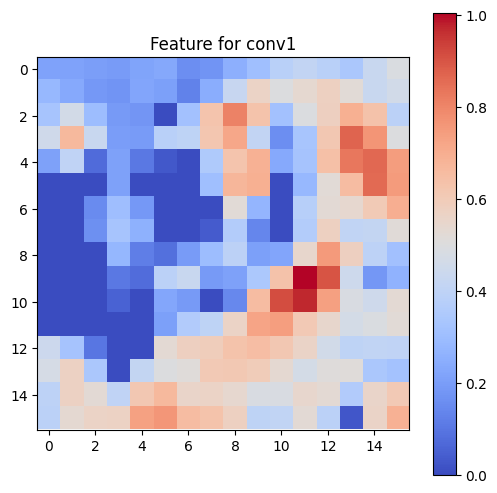

In [23]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

output = model.infer(images, device)
features = model.get_features()

image = 0
channel = 0
layer_name = 'conv1'
f = features[layer_name][image][channel]

plt.figure(figsize=(6, 6))
plt.title(f"Feature for {layer_name}")
plt.imshow(f.cpu().numpy(), cmap='coolwarm')
plt.colorbar()
plt.show()

## Plot Feature Matrices

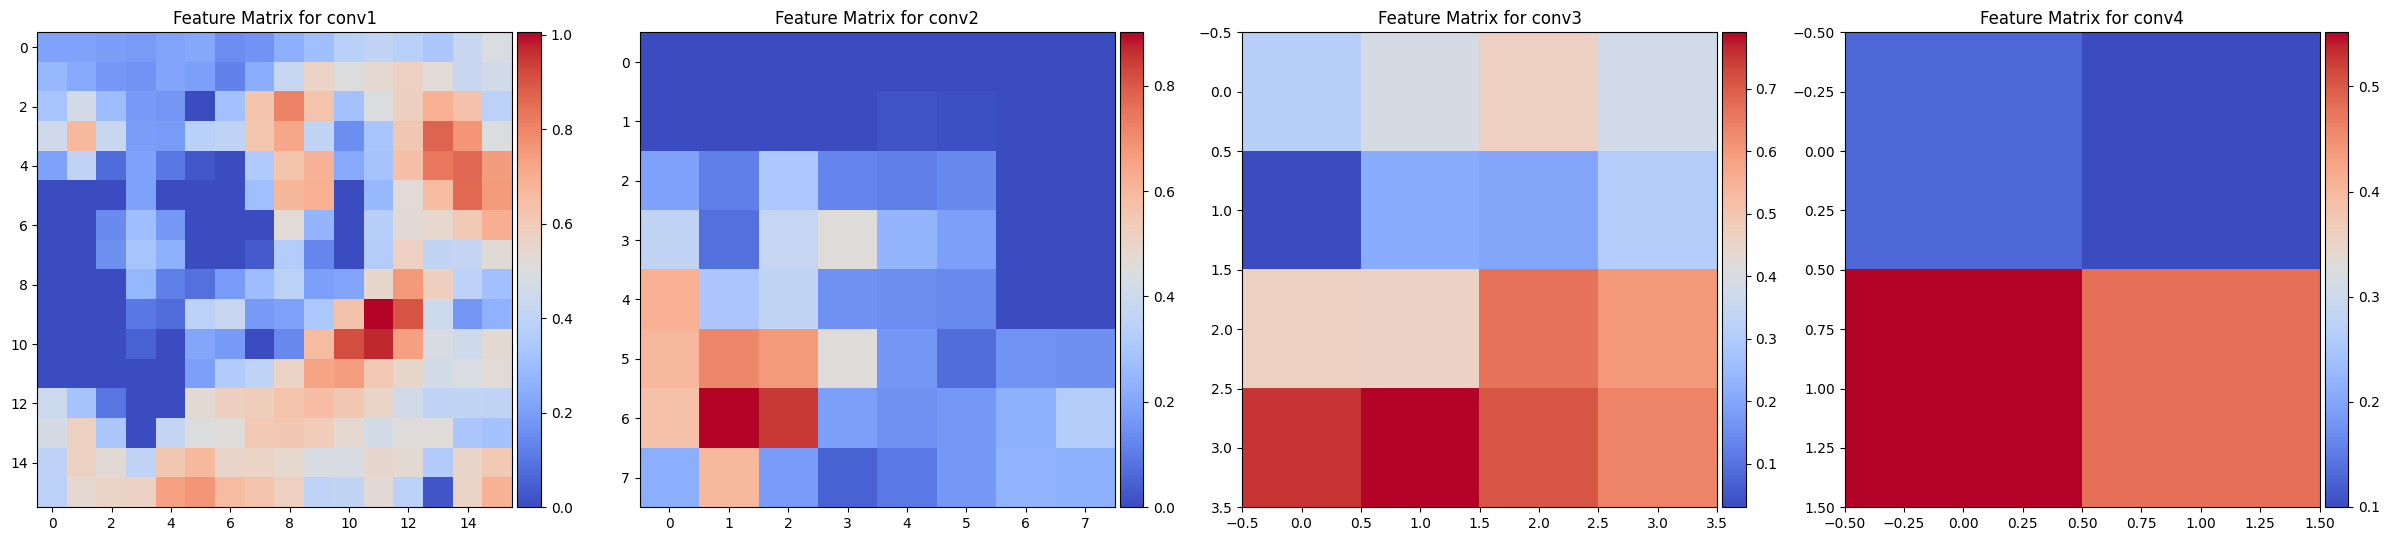

In [24]:
def plot_features(features, image=0, channel=0):
    num_features = len(features)
    num_rows = 1
    num_cols = num_features
    layer_names = list(features.keys())
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6 * num_rows))
    
    for f_index, layer_name in enumerate(layer_names):
        ax = axs[f_index]
        ax.set_title(f"Feature Matrix for {layer_name}")
        im = ax.imshow(features[layer_name][image][channel].cpu().numpy(), cmap='coolwarm')
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        plt.tight_layout()
        plt.savefig('features.png')
        # plt.show()

plot_features(features)

## Calculate Gram Matrices

In [109]:
def calculate_gram_matrices(features, triang='upper'):
    processed_gram_matrices = {}
    
    layer_names = list(features.keys())    
    num_layers = len(features)    
    num_images = features[layer_names[0]].size()[0]
    num_channels = features[layer_names[0]].size()[1]

    processed_gms = []
    for layer_index, layer_name in enumerate(layer_names):
        processed_imgs = []
        for img_index, img in enumerate(features[layer_name]):
            processed_chs = []
            for ch_index, channel in enumerate(img):
                gram_matrix = torch.mm(channel, channel.t())

                if triang=='upper':
                    gram_matrix = torch.triu(gram_matrix)
                elif triang=='lower':
                    gram_matrix = torch.tril(gram_matrix)

                gram_matrix = normalize(gram_matrix, p=2.0, dim = 0)
                gram_matrix = gram_matrix.cpu()
                
                processed_chs.append(gram_matrix)
            processed_imgs.append(processed_chs)
        processed_gms.append(processed_imgs)

    for layer_index, layer_name in enumerate(layer_names):
        processed_gram_matrices[layer_name] = torch.tensor(np.array(processed_gms[layer_index]))

    return processed_gram_matrices

## Plor Gram Matrices

In [242]:
def plot_gram_matrices(grams_matrices, desc='Gram Matrix for', image=0, channel=0, cmap='coolwarm', fontsize=18):
    num_grams = len(grams_matrices)
    num_rows = 1
    num_cols = num_grams
    layer_names = list(grams_matrices.keys())
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6 * num_rows))
    
    for g_index, layer_name in enumerate(layer_names):
        ax = axs[g_index]
        ax.set_title(f"{desc} {layer_name}", fontsize=fontsize, y=1.04)
        im = ax.imshow(grams_matrices[layer_name][image][channel].cpu().numpy(), cmap=cmap)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        plt.tight_layout()
        plt.savefig('fig_gram_matrices.png')
        # plt.show()

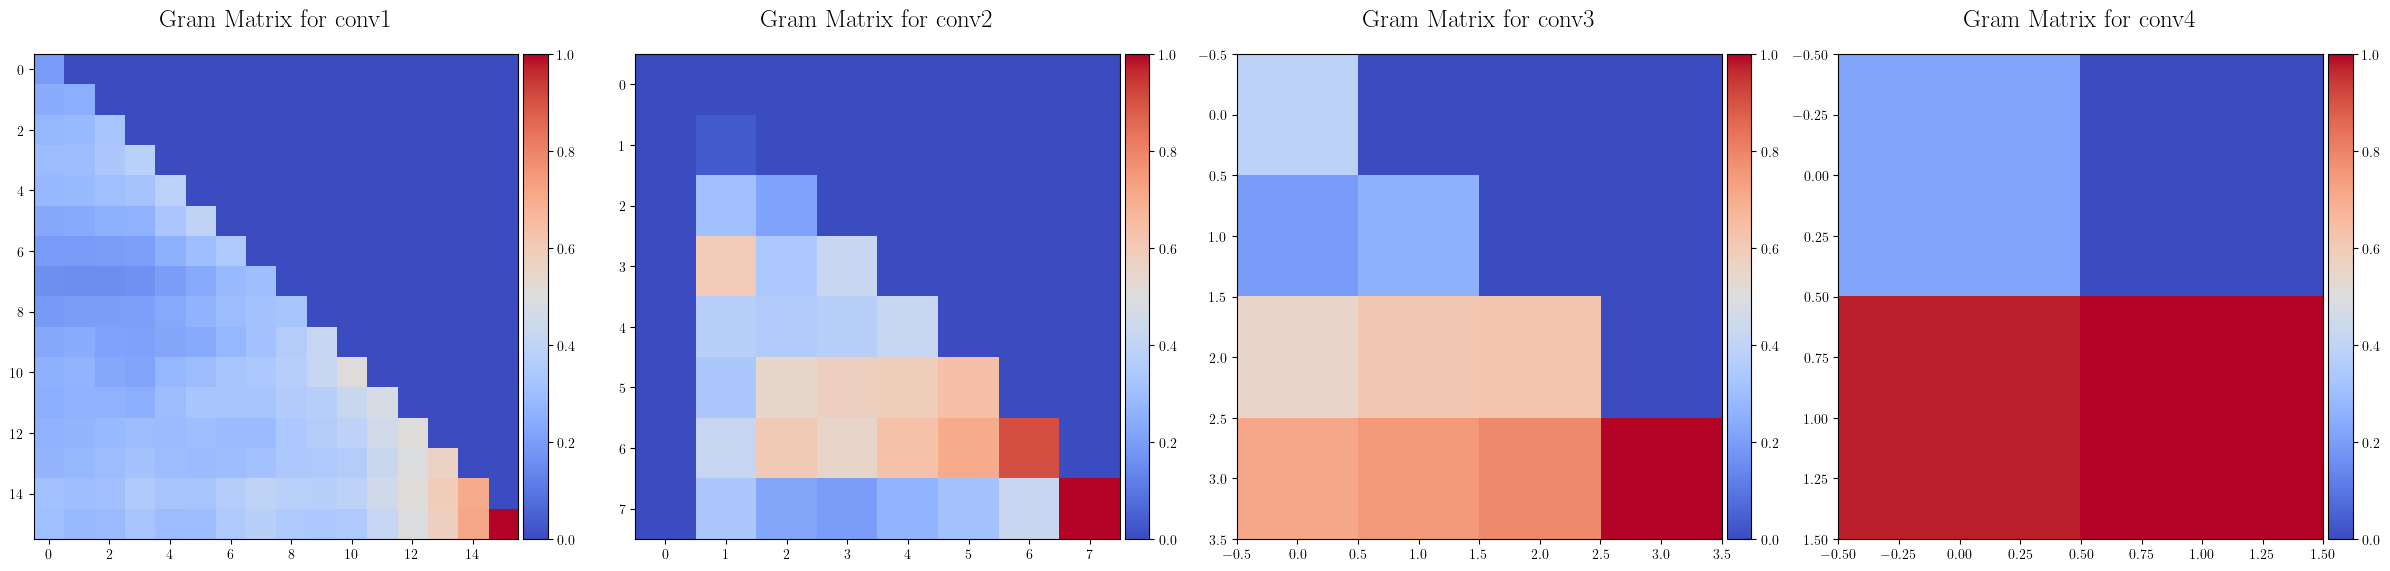

In [243]:
grams = calculate_gram_matrices(features, triang='lower')
plot_gram_matrices(grams)

## Calculate Mean and STD Gram Matrices

In [244]:
def get_mean_std_gram(grams_matrices):
    num_layers = len(grams_matrices)
    num_samples = grams_matrices[list(grams_matrices.keys())[0]].size()[0]
    num_channels = grams_matrices[list(grams_matrices.keys())[0]].size()[1]
    gram_size = grams_matrices[list(grams_matrices.keys())[0]].size()[2:]

    mean_grams = {layer_name: torch.unsqueeze(torch.unsqueeze(torch.zeros(size=(grams_matrices[layer_name].size()[2:])), dim=0), dim=0)  for l_index, layer_name in enumerate(list(grams_matrices.keys()))}
    std_grams = {layer_name: torch.unsqueeze(torch.unsqueeze(torch.zeros(size=(grams_matrices[layer_name].size()[2:])), dim=0), dim=0)  for l_index, layer_name in enumerate(list(grams_matrices.keys()))}

    for l_index, layer_name in enumerate(list(grams_matrices.keys())): 
        for sample in grams_matrices[layer_name]:
            for ch in sample:  
                mean_grams[layer_name][0][0] = mean_grams[layer_name][0][0] + ch
                std_grams[layer_name][0][0] = torch.square(ch - mean_grams[layer_name][0][0])
            mean_grams[layer_name][0][0] = mean_grams[layer_name][0][0] / num_channels
            std_grams[layer_name][0][0] = std_grams[layer_name][0][0] / num_channels
        mean_grams[layer_name][0][0] = mean_grams[layer_name][0][0] / num_samples
        mean_grams[layer_name][0][0] = normalize(mean_grams[layer_name][0][0], p=2.0, dim = 0)
        
        std_grams[layer_name][0][0] = std_grams[layer_name][0][0] / num_samples
        # std_grams[layer_name][0][0] = normalize(torch.mul(std_grams[layer_name][0][0], np.random.normal(1, 2)), p=2.0, dim = 0)
        std_grams[layer_name][0][0] = normalize(std_grams[layer_name][0][0], p=2.0, dim = 0)
    
    return mean_grams, std_grams

grams = calculate_gram_matrices(features, triang='lower')
mean_grams, std_grams = get_mean_std_gram(grams)

## Save Gram Matrices

In [245]:
with open('mean_grams.pkl', 'wb') as f:
    pickle.dump(mean_grams, f)
with open('std_grams.pkl', 'wb') as f:
    pickle.dump(std_grams, f)

## Load Gram Matrices

In [295]:
with open('mean_grams.pkl', 'rb') as f:
    mean_grams = pickle.load(f)

with open('std_grams.pkl', 'rb') as f:
    std_grams = pickle.load(f)

## Generate ID Sample Gram Matrices

In [296]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

output = model.infer(images, device)
features = model.get_features()

image = 5
channel = 3
features_id = {layer_name: torch.unsqueeze(torch.unsqueeze(normalize(features[layer_name][image][channel], p=2.0, dim = 0), dim=0), dim=0)  for l_index, layer_name in enumerate(list(features.keys()))}
grams_id = calculate_gram_matrices(features_id, triang='lower')

## Generate OOD Sample Gram Matrices

In [297]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

output = model.infer(images, device)
features = model.get_features()

image = 10
channel = 6
# f_ood = {layer_name: torch.unsqueeze(torch.unsqueeze(normalize(torch.mul(features[layer_name][image][channel], np.random.normal(1, 100)), p=2.0, dim = 0), dim=0), dim=0)  for l_index, layer_name in enumerate(list(features.keys()))}
features_ood = {layer_name: torch.unsqueeze(torch.unsqueeze(normalize(features[layer_name][image][channel], p=2.0, dim = 0), dim=0), dim=0)  for l_index, layer_name in enumerate(list(features.keys()))}
grams_ood = calculate_gram_matrices(features, triang='lower')

## Plot All Matrices

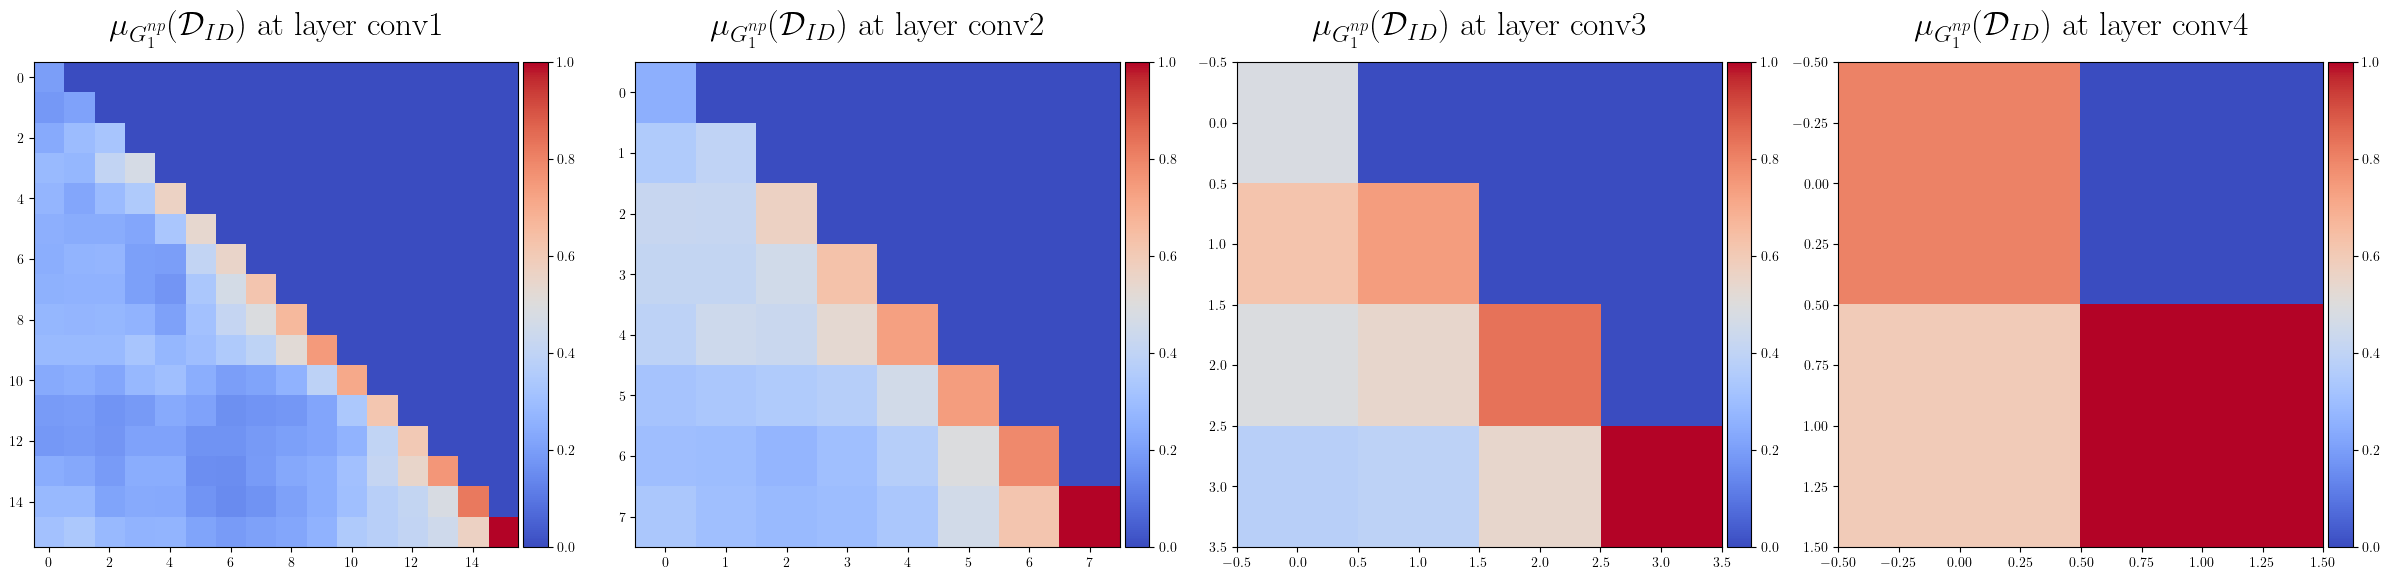

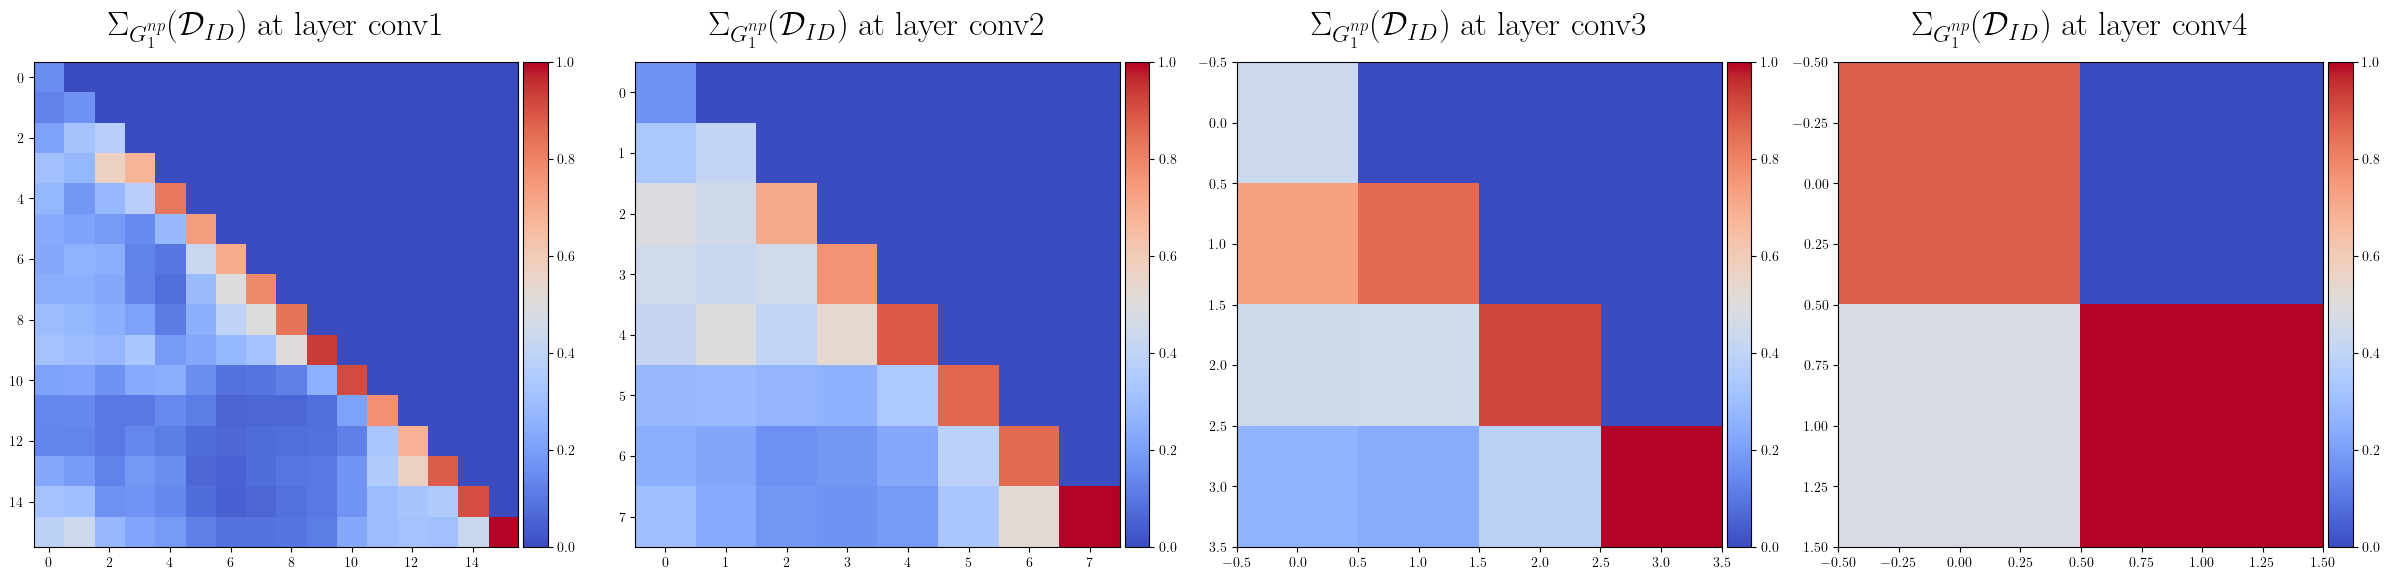

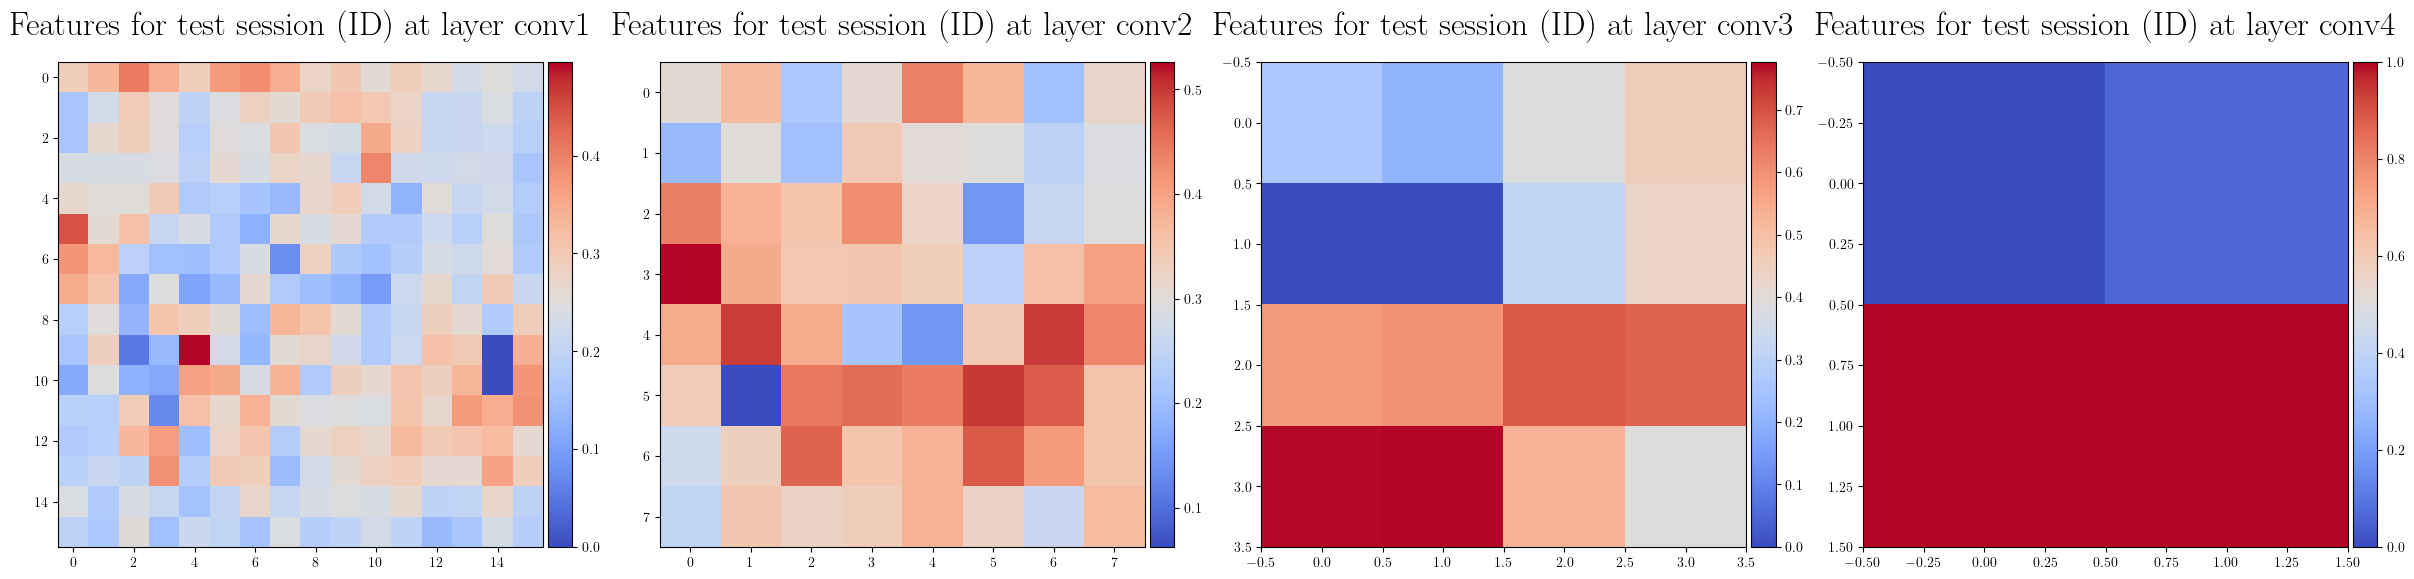

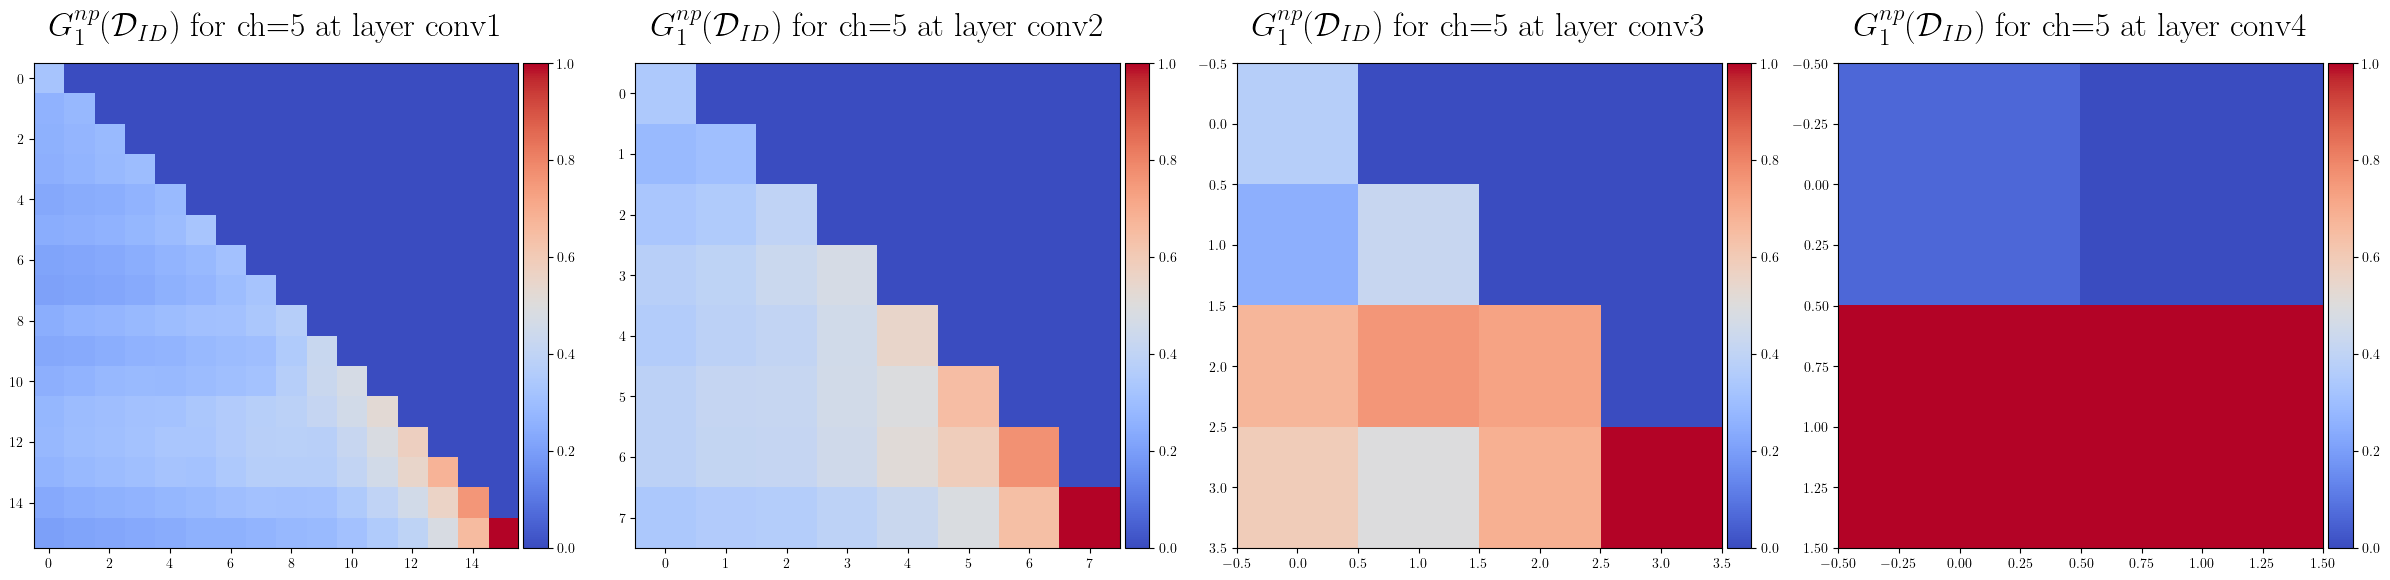

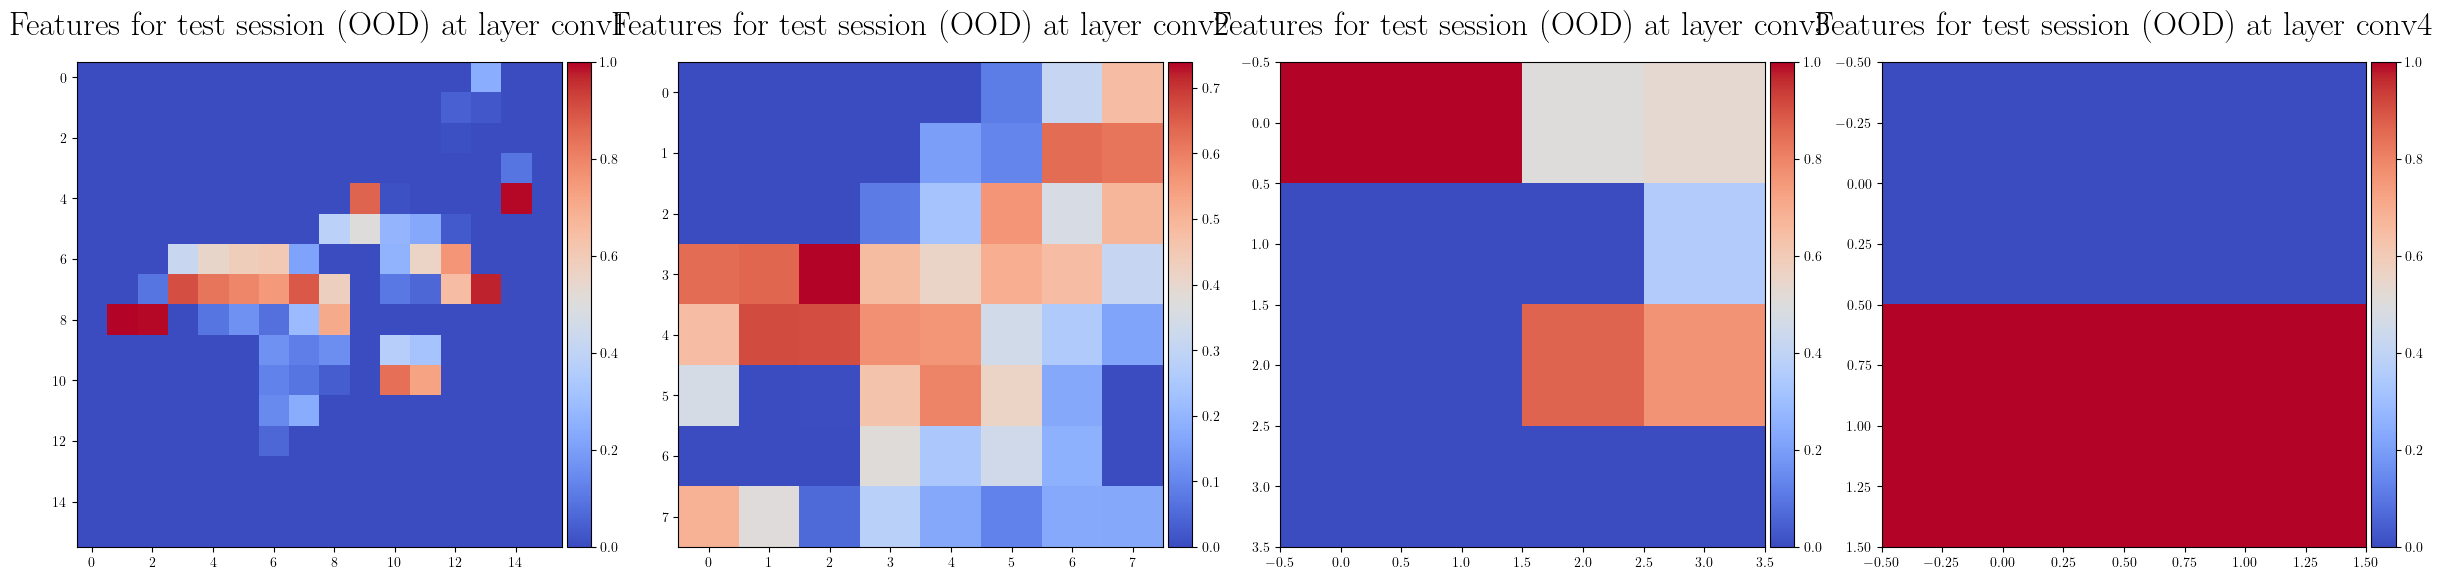

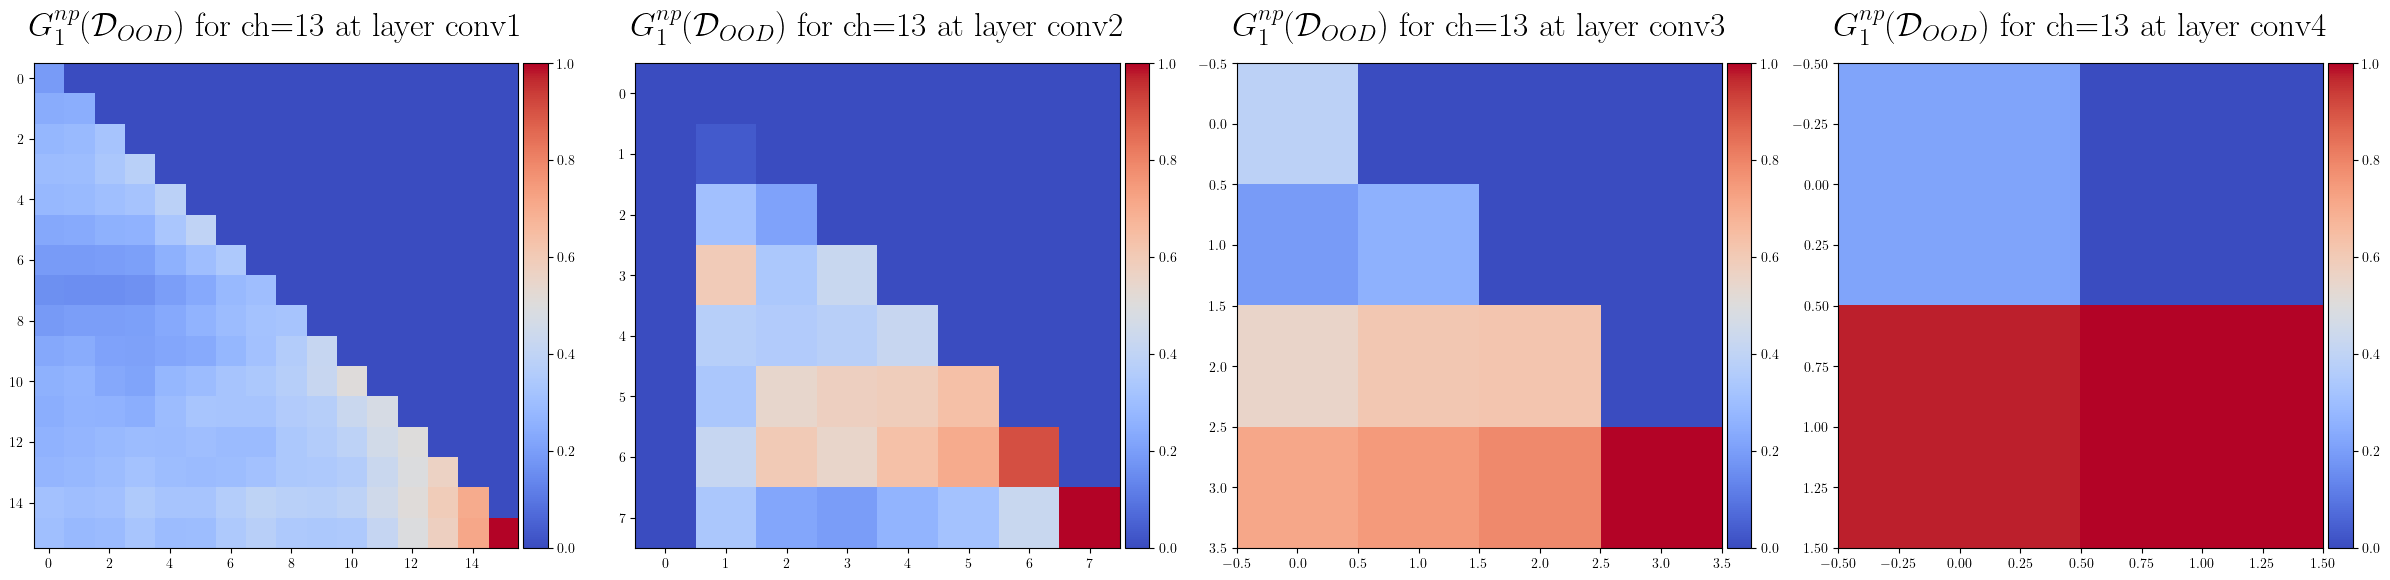

In [298]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'Times New Roman'
})
font_size = 24

plot_gram_matrices(mean_grams, desc='\(\mu_{G^{np}_1} (\mathcal{D}_{ID})\) at layer ', fontsize=font_size)
plot_gram_matrices(std_grams, desc='\(\Sigma_{G^{np}_1} (\mathcal{D}_{ID})\) at layer ', fontsize=font_size)

plot_gram_matrices(f_id, desc='Features for test session (ID) at layer ', fontsize=font_size)
plot_gram_matrices(grams_id, desc='\(G^{np}_1 (\mathcal{D}_{ID})\) for ch=5 at layer ', fontsize=font_size)

plot_gram_matrices(f_ood, desc='Features for test session (OOD) at layer ', fontsize=font_size)
plot_gram_matrices(grams_ood, desc='\(G^{np}_1 (\mathcal{D}_{OOD})\) for ch=13 at layer ', fontsize=font_size)

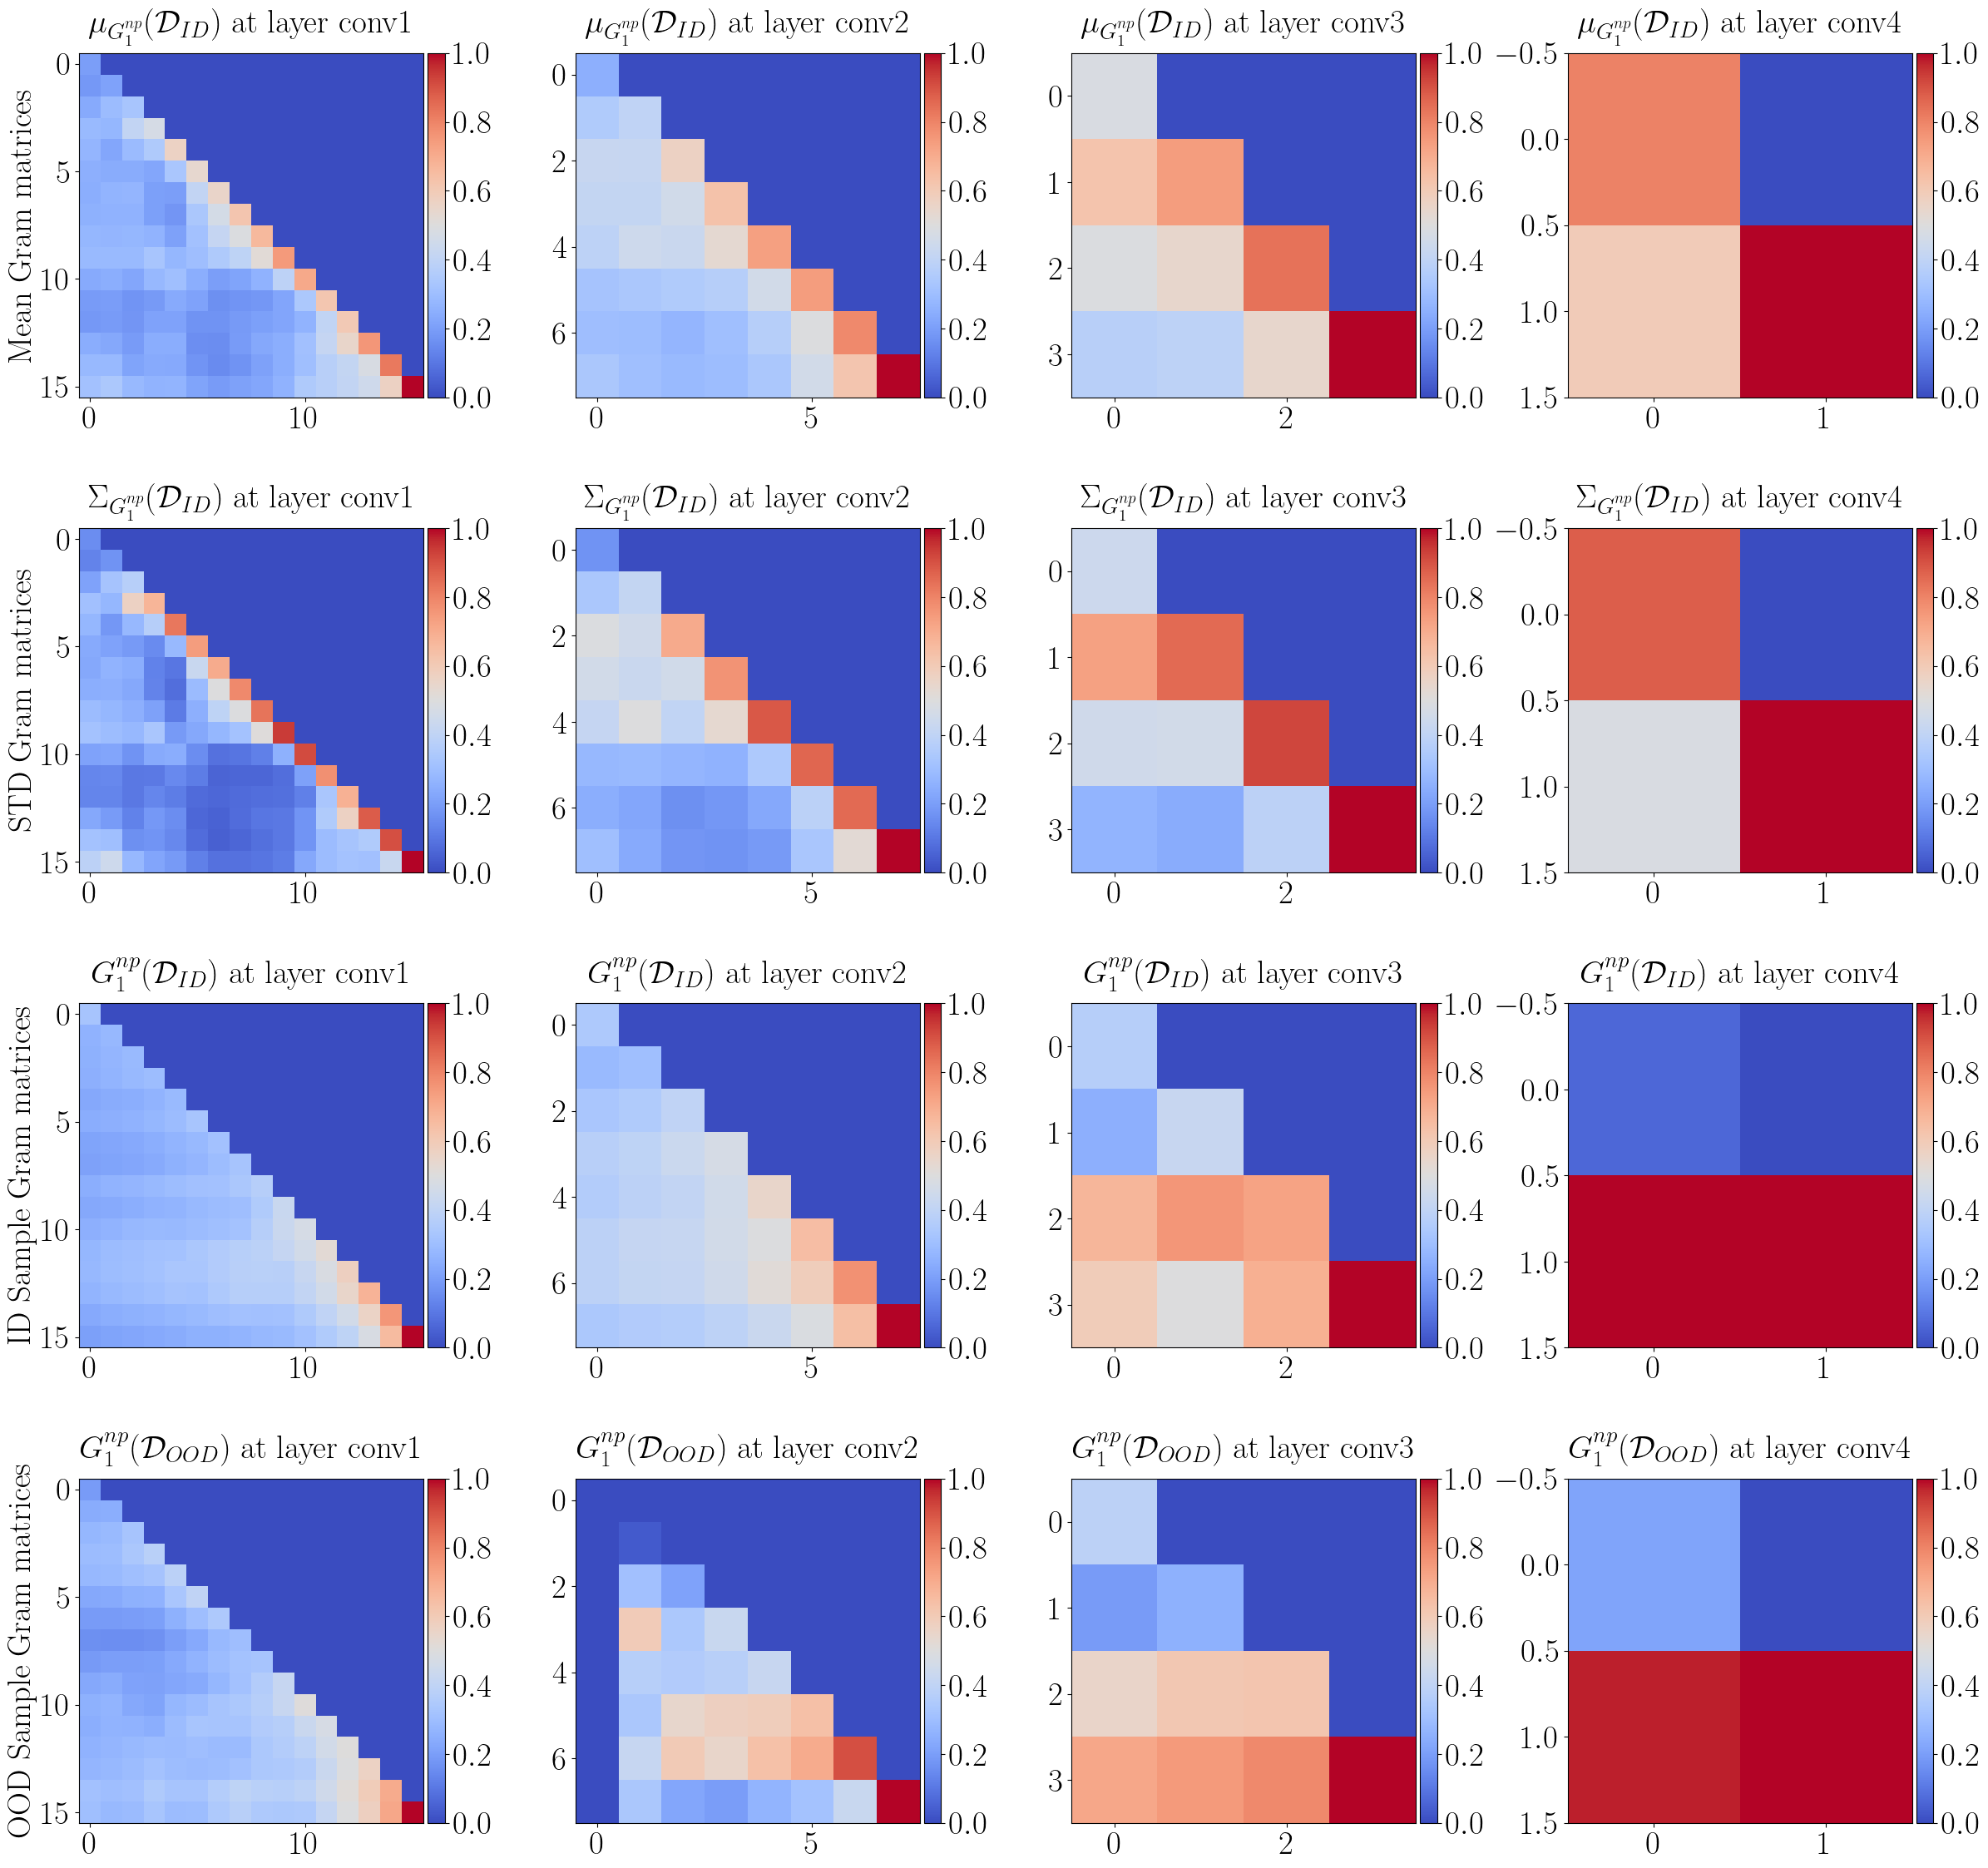

In [308]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'Times New Roman'
})
font_size = 28

data = [{'matrix': mean_grams, 'desc': '\(\mu_{G^{np}_1} (\mathcal{D}_{ID})\) at layer ', 'ylabel': 'Mean Gram matrices'},
        {'matrix': std_grams, 'desc': '\(\Sigma_{G^{np}_1} (\mathcal{D}_{ID})\) at layer ', 'ylabel': 'STD Gram matrices'},
        # {'matrix': features_id, 'desc': '\(\F_1 (\mathcal{D}_{ID})\) at layer '},
        {'matrix': grams_id, 'desc': '\(G^{np}_1 (\mathcal{D}_{ID})\) at layer ', 'ylabel':'ID Sample Gram matrices'},
        # {'matrix': features_ood, 'desc': '\(\F_1 (\mathcal{D}_{OOD})\) at layer '},
        {'matrix': grams_ood, 'desc': '\(G^{np}_1 (\mathcal{D}_{OOD})\) at layer ', 'ylabel':'OOD Sample Gram matrices'}]


def plot_all_gram_matrices(data, fontsize = font_size):
    image=0
    channel=0
    cmap='coolwarm'
    num_rows = len(data)
    num_cols = len(data[0]['matrix'])

        
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6 * num_rows))

    for matrix_index in range(0, num_rows):
        matrix = data[matrix_index]['matrix']
        num_grams = len(matrix)
        layer_names = list(matrix.keys())
        
        for g_index, layer_name in enumerate(layer_names):
            ax = axes[matrix_index, g_index]
            ax.set_title(f"{data[matrix_index]['desc']} {layer_name}", fontsize=fontsize, y=1.04)
            im = ax.imshow(matrix[layer_name][image][channel].cpu().numpy(), cmap=cmap)

            if g_index==0:
                ax.set_ylabel(f"{data[matrix_index]['ylabel']}", rotation=90, fontsize=fontsize)

            ax.tick_params(axis='both', which='major', labelsize=fontsize)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax)
            cbar.ax.tick_params(labelsize=fontsize) 
            plt.tight_layout()
                
    plt.savefig('fig_gram_matrices.png')


plot_all_gram_matrices(data=data, fontsize=font_size)